In [76]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [77]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [78]:
df = pd.read_csv(data)
print(f"Data loaded successfully! Shape: {df.shape}")
df.head()

Data loaded successfully! Shape: (9704, 11)


,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


## Preparation

In [79]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [80]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [81]:
numericalColumnsWithMissingValues = ['num_cylinders', 'horsepower', 'acceleration', 'num_doors']

for col in numericalColumnsWithMissingValues:
    df[col] = df[col].fillna(0)

df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [82]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [83]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

In [84]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [85]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [86]:
print(export_text(dt, feature_names = list(dv.get_feature_names_out())))

|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Question 2

In [87]:
from sklearn.ensemble import RandomForestRegressor

In [88]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [89]:
y_pred = rf.predict(X_val)

In [90]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [91]:
print(f"{rmse(y_val, y_pred):.3f}")

0.459


## Question 3

In [92]:
from matplotlib import pyplot as plt
%matplotlib inline

In [93]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    n_rmse = rmse(y_val, y_pred)
    
    scores.append((n, n_rmse))

In [94]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'root_mean_squared_error'])
df_scores['root_mean_squared_error'] = df_scores['root_mean_squared_error'].round(3)
df_scores

,n_estimators,root_mean_squared_error
0,10,0.459
1,20,0.454
2,30,0.451
3,40,0.448
4,50,0.446
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


## Question 4

In [95]:
import seaborn as sns

In [96]:
scores = []

for n in range(10, 201, 10):
    for m in range(10, 26, 5):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, max_depth=m)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        n_rmse = rmse(y_val, y_pred)
        
        scores.append((n, m, n_rmse))

In [97]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'root_mean_squared_error'])
df_scores['root_mean_squared_error'] = df_scores['root_mean_squared_error'].round(3)
pivot_table = df_scores.pivot(index='n_estimators', columns='max_depth', values='root_mean_squared_error')

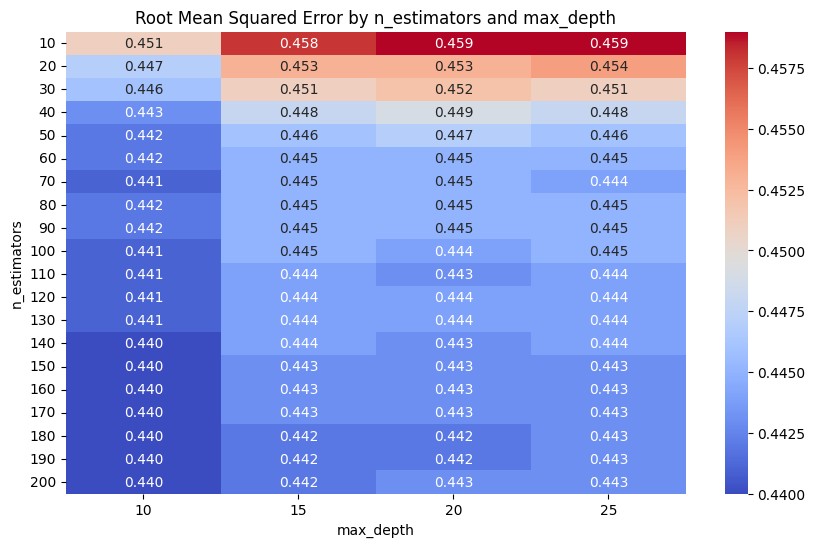

In [98]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="coolwarm")
plt.title('Root Mean Squared Error by n_estimators and max_depth')
plt.ylabel('n_estimators')
plt.xlabel('max_depth')
plt.show()

## Question 5

In [99]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, max_depth=20)

rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [100]:
feature_names = dv.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

feature_importance_df['importance'] = feature_importance_df['importance'].round(3)


In [101]:
feature_importance_df

,feature,importance
13,vehicle_weight,0.959
6,horsepower,0.016
0,acceleration,0.011
3,engine_displacement,0.003
7,model_year,0.003
8,num_cylinders,0.002
9,num_doors,0.002
12,origin=USA,0.001
11,origin=Europe,0.001
10,origin=Asia,0.000


## Question 6

In [118]:
import xgboost as xgb

In [119]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [120]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [121]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)

root_mean_squared_error = rmse(y_val, y_pred)

print(root_mean_squared_error)

0.45017755678087246


In [122]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [123]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

y_pred = model.predict(dval)

root_mean_squared_error = rmse(y_val, y_pred)

print(root_mean_squared_error)

0.42622800553359225
